# README

TODO

# Libraries

In [1]:
#Preparing all libraries
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import numpy as np
import pandas as pd
import scipy
# import addcopyfighandler
import statistics
import math
import time
from ripser import ripser
from tqdm import trange
from matplotlib import cm
import colorsys
from datetime import date
import pickle
import functools
import os
from matplotlib.ticker import MultipleLocator

# Initialization

### Window Analysis

In [2]:
cwd_temp = os.getcwd()
base_file = 'Stabilization'
cwd_full = cwd_temp.split(base_file, 1)[0]
print(cwd_full)

exp_file = 'PDF_Bayes_Freq'
data_file = 'TDA_freq_DATA'
exp_date = '08May24'
run_head = 'trueStart'

SNR_value = 1000
var_reps = 1000000

add_tag = ""

param_oi = 2

assert(param_oi >= 0 and param_oi < 6)

ParamTitle_6p = [r'$T_{11}$', r'$T_{12}$', r'$c_1$', r'$c_2$', r'$T_{21}$', r'$T_{22}$']
ParamTitle_4p = [r'$d_1$', r'$d_2$', r'$T_{21}$', r'$T_{22}$']

/home/hamptong2/


In [3]:
with open(f'{cwd_full}{base_file}/{exp_file}/{data_file}/hprParameter_{run_head}_SNR{SNR_value}_iter{var_reps}_{add_tag}{exp_date}.pkl', 'rb') as handle:
    
    dict = pickle.load(handle)
    check_SNR_value = dict['SNR_value']
    TI_DATA = dict['TI_DATA']
    true_params = dict["true_params"]
    nTE = dict["nTE"]
    dTE = dict["dTE"]
    check_var_reps = dict["var_reps"]
    rand_start = dict["rand_start"]
    handle.close()

T11, T12, c1, c2, T21, T22 = true_params

TI1star = np.log(2)*T11
TI2star = np.log(2)*T12

assert(SNR_value == check_SNR_value)
assert(check_var_reps == var_reps)

details = f"\nSNR {SNR_value} :: iterations {var_reps}\n{ParamTitle_6p} = [{T11} {T12} {c1} {c2}, {T21}, {T22}]"

# Functions

In [4]:
def to_readable_2DWindow(file):
    df = pd.read_pickle(file)
    ALL_TI = np.stack(df["TI"].values) #shape: 
    ALL_TD_params = np.stack(df["params1"].values) #shape: 
    ALL_OD_params = np.stack(df["params2"].values) #shape: 
    ALL_TD_RSS = np.stack(df["RSS1"].values) #shape: 
    ALL_OD_RSS = np.stack(df["RSS2"].values) #shape:
    ALL_NR = np.stack(df["NR"].values) #shape:

    return ALL_TI, ALL_TD_params, ALL_OD_params, ALL_TD_RSS, ALL_OD_RSS, ALL_NR

def d_value(TI,c,T1):
    return c*(1-2*np.exp(-TI/T1))

def _get_colors(num_colors):
    colors = []
    for i in np.arange(0., 360., 360. / num_colors):
        hue = i/360.
        lightness = (50 + np.random.rand() *10)/100.
        saturation = (90 + np.random.rand() * 10)/100.
        colors.append(colorsys.hls_to_rgb(hue, lightness, saturation))
    return colors

In [5]:
def prepare_data():
    # ordering = ["ESPRESSO", "Conventional", "Curve Fit"]
    params1_ordered = np.zeros((len(TI_DATA), var_reps//2, 4))
    params2_ordered = np.zeros((len(TI_DATA), var_reps//2, 4))
    RSS1_ordered = np.zeros((len(TI_DATA), var_reps//2))
    RSS2_ordered = np.zeros((len(TI_DATA), var_reps//2))
    
    data_name = f"{cwd_full}{base_file}/{exp_file}/{data_file}/{run_head}_SNR{SNR_value}_iter{var_reps}_{add_tag}{exp_date}.pkl"

    print("Retrieving data for " + data_name)
    TI, param1, param2, RSS1, RSS2, NR = to_readable_2DWindow(data_name)

    for index in range(len(TI)):

        temp_TI = TI[index]

        TI_index = np.where(temp_TI==TI_DATA)[0][0]

        nr_index = NR[index]

        params1_ordered[TI_index,nr_index,:] = param1[index,:]
        params2_ordered[TI_index,nr_index,:] = param2[index,:]
        RSS1_ordered[TI_index,nr_index] = RSS1[index]
        RSS2_ordered[TI_index,nr_index] = RSS2[index]

    # params = np.append(params1_ordered, params2_ordered)
    # RSS = np.append(RSS1_ordered, RSS2_ordered)

    return np.append(params1_ordered, params2_ordered, axis=1), np.append(RSS1_ordered, RSS2_ordered, axis=1)

# Data Organization

In [6]:
start = time.time()
param_estimates, RSS = prepare_data()
end = time.time()
print(f"Elapsed Time = {end-start} seconds")

Retrieving data for /home/hamptong2/Stabilization/PDF_Bayes_Freq/TDA_freq_DATA/trueStart_SNR1000_iter1000000_08May24.pkl
Elapsed Time = 164.4774887561798 seconds


In [7]:
print(param_estimates.shape)

(16, 1000000, 4)


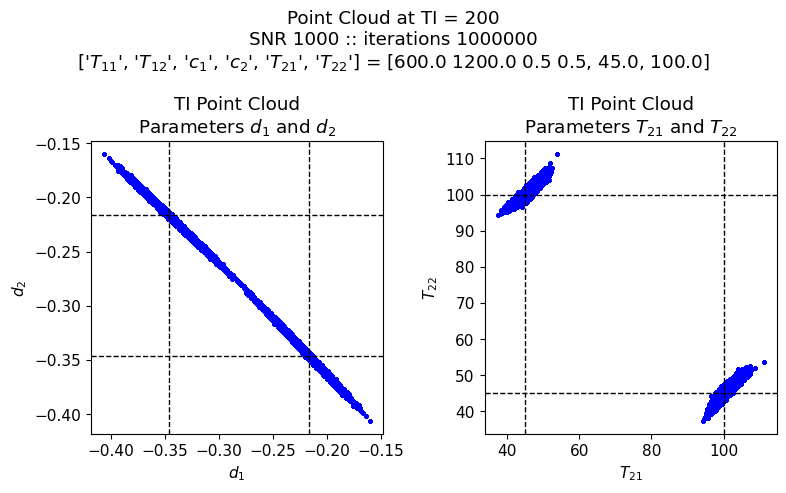

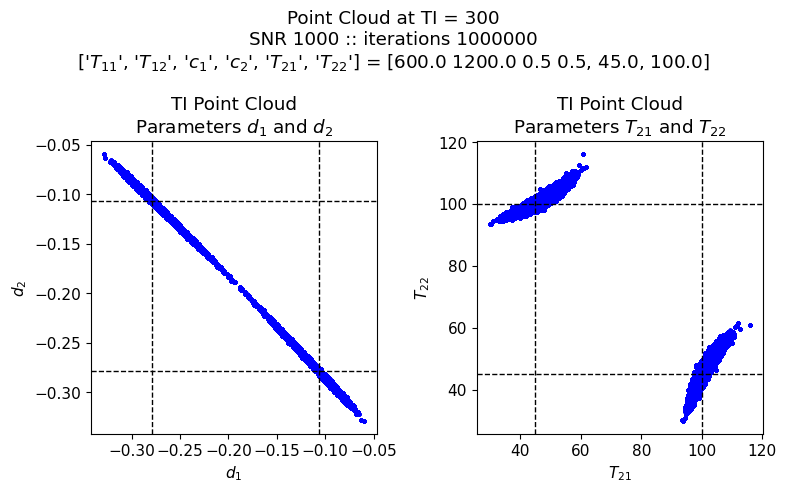

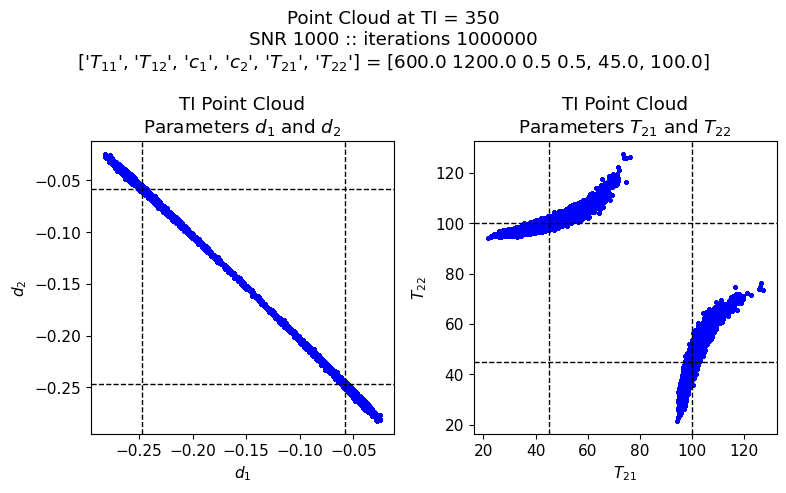

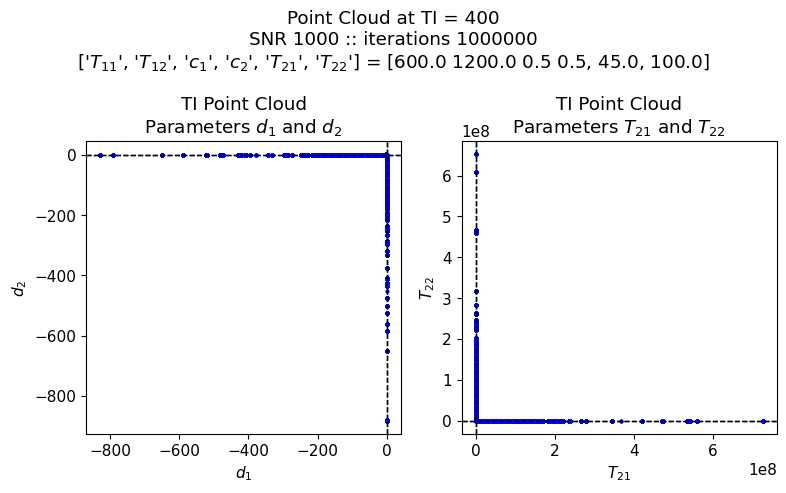

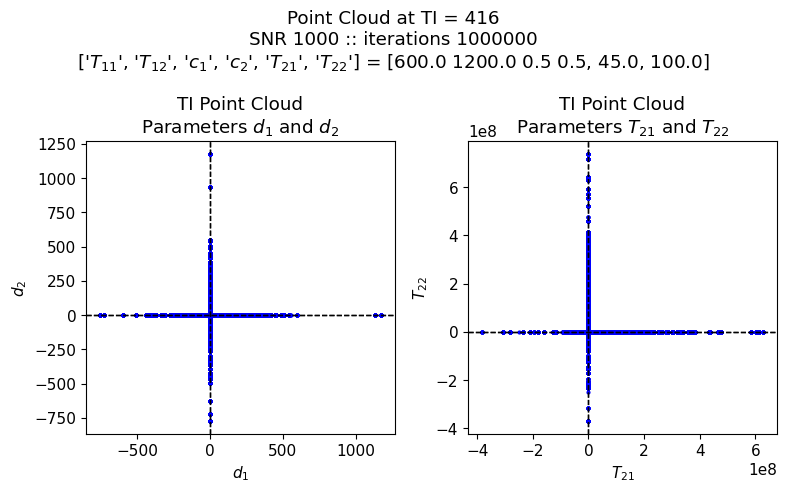

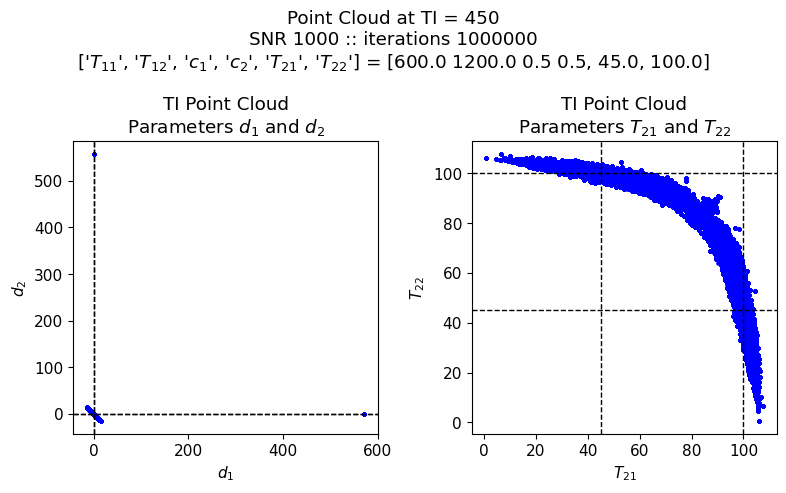

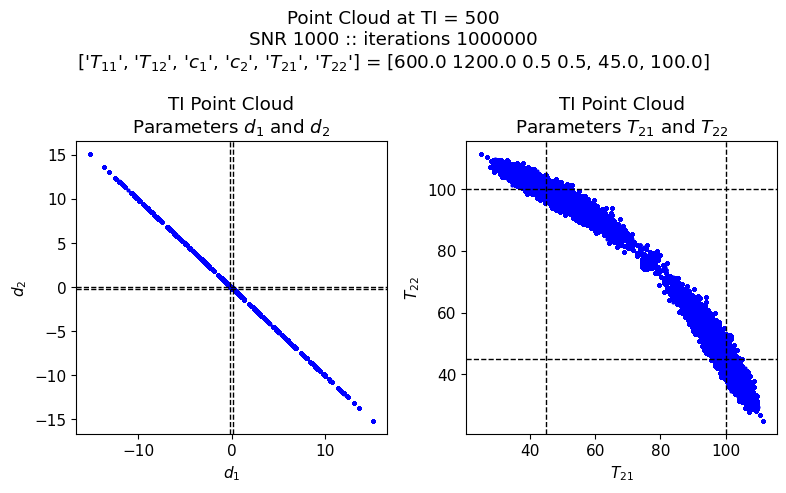

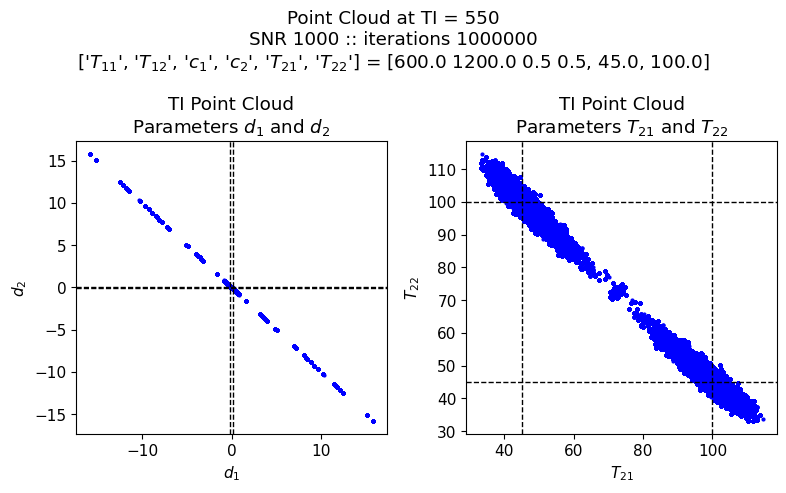

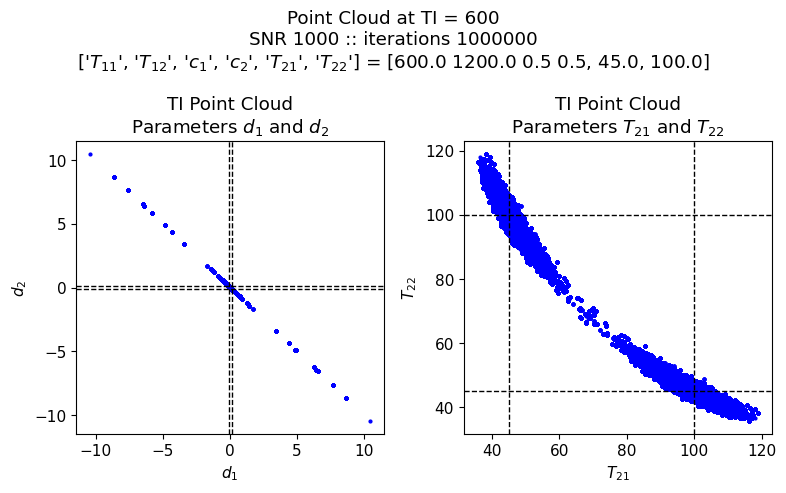

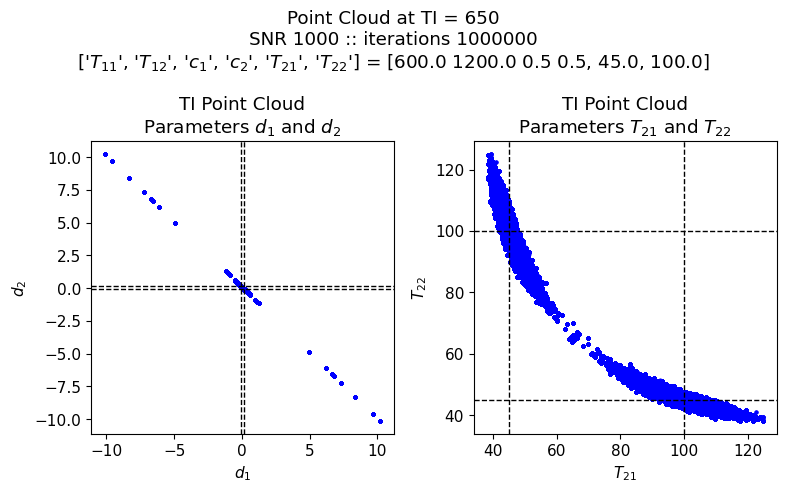

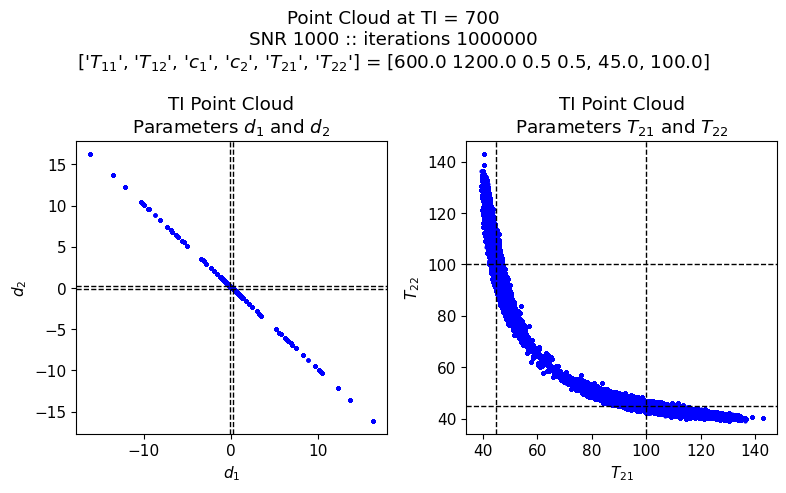

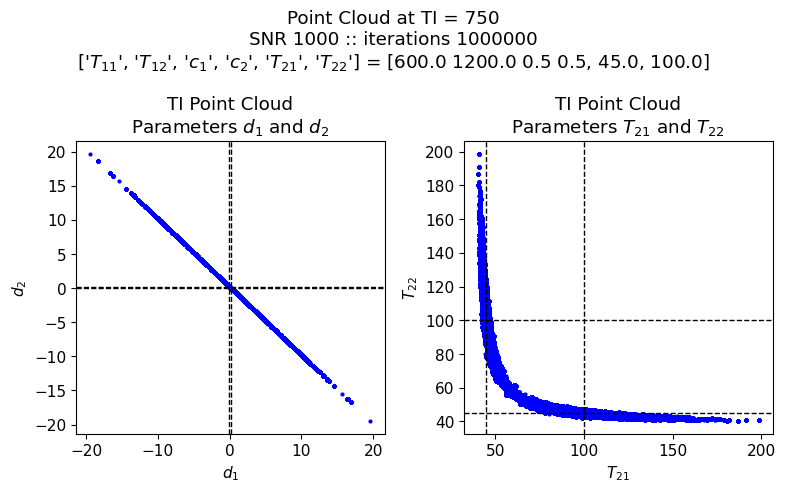

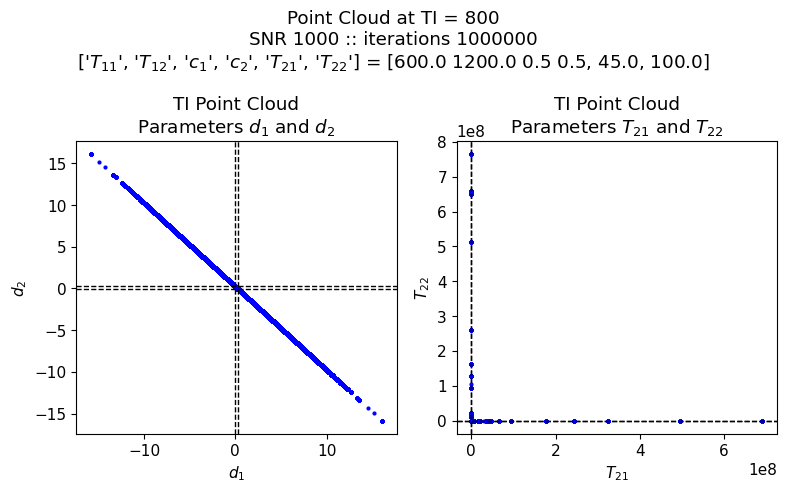

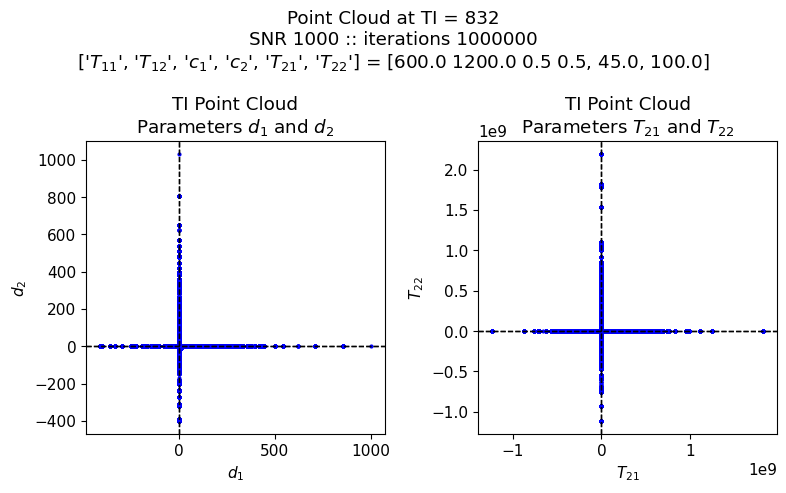

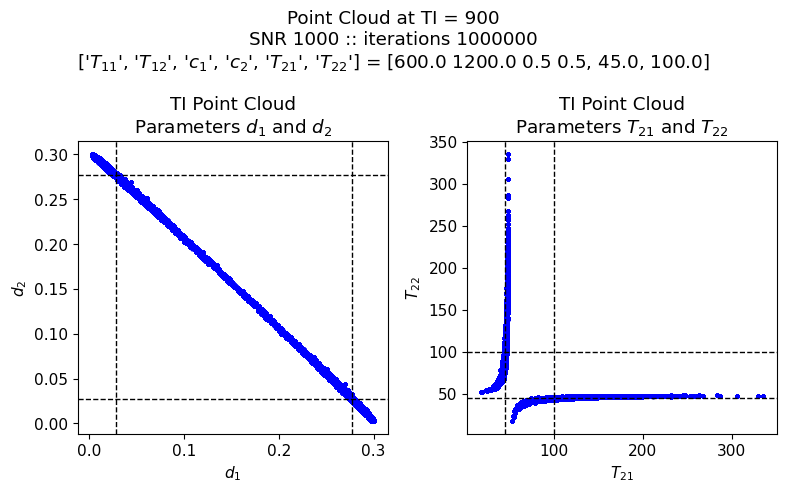

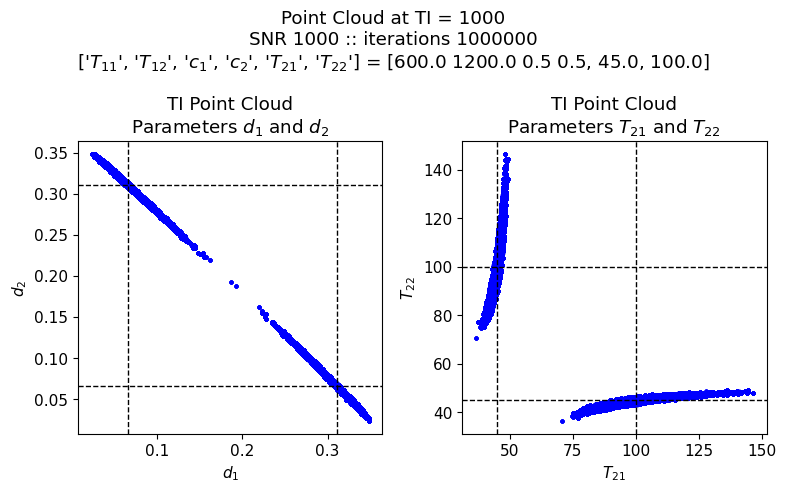

In [20]:
for iTI in range(len(TI_DATA)):
    TI_oi = TI_DATA[iTI]

    temp_true_params = [d_value(TI_oi, c1, T11), d_value(TI_oi, c2, T12), T21, T22]

    fig, ax = plt.subplots(1,2, figsize=(8,5), tight_layout=True)
    plt.rc('font', size = 11)
    fig.suptitle(f'Point Cloud at TI = {TI_oi}' + details)
    for i in range(2):
        ax[i].plot(param_estimates[iTI,:,2*i], param_estimates[iTI,:,2*i+1], ls = '', color='b', marker = 'o', markersize = 2)
        ax[i].axvline(x = temp_true_params[2*i], linewidth=1, color='k', ls = '--')
        ax[i].axvline(x = temp_true_params[2*i+1], linewidth=1, color='k', ls = '--')
        ax[i].axhline(y = temp_true_params[2*i], linewidth=1, color='k', ls = '--')
        ax[i].axhline(y = temp_true_params[2*i+1], linewidth=1, color='k', ls = '--')
        ax[i].set_xlabel(ParamTitle_4p[2*i])
        ax[i].set_ylabel(ParamTitle_4p[2*i+1])
        ax[i].set_title(f'TI Point Cloud\nParameters {ParamTitle_4p[2*i]} and {ParamTitle_4p[2*i+1]}')
        # ax[i].legend()
    plt.show()

200
300
350
400


416
450
500
550
600
650
700
750
800
832
900
1000


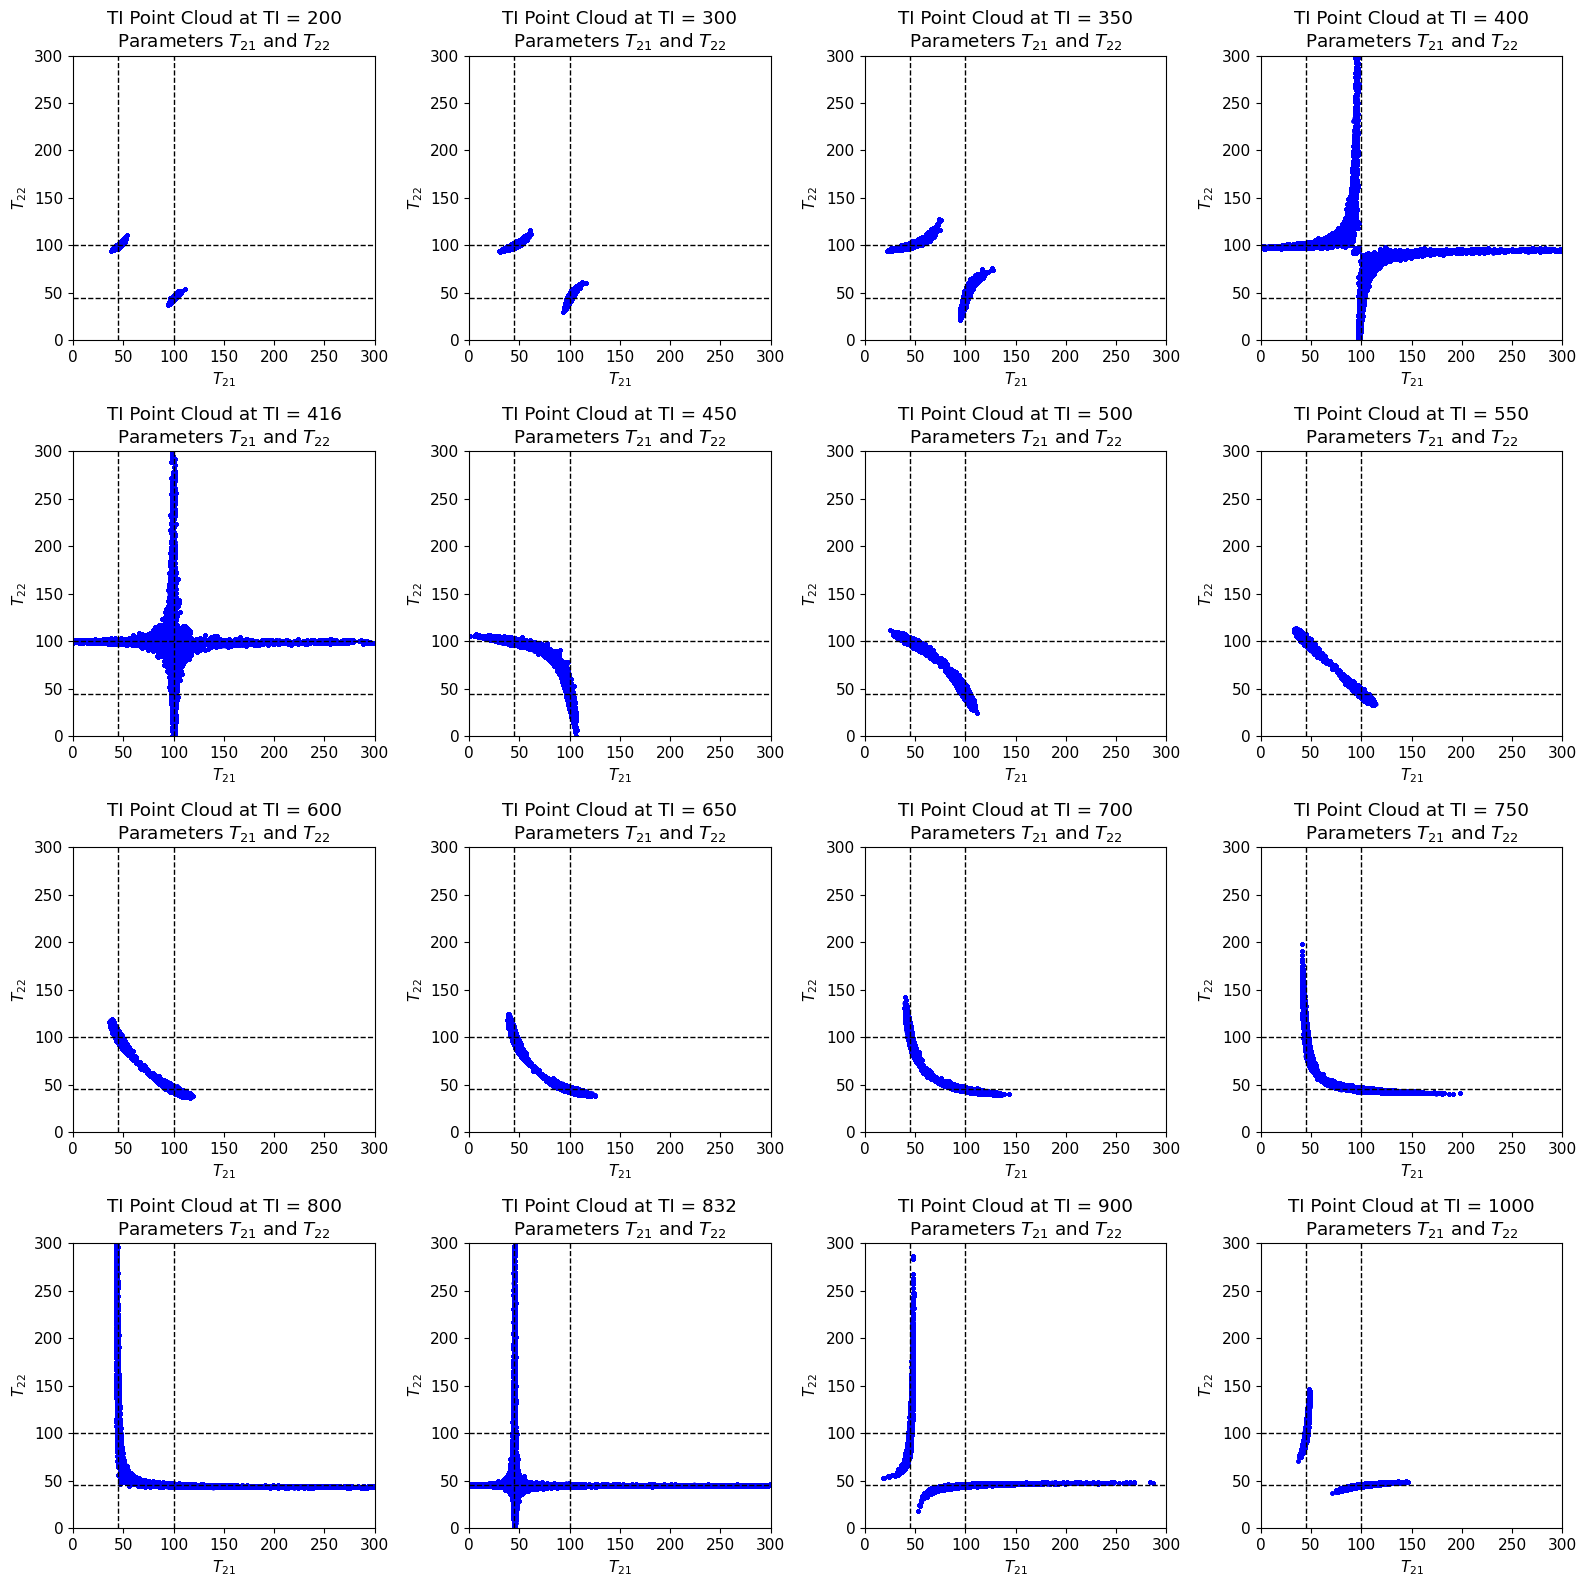

In [23]:
fig, ax = plt.subplots(4,4, figsize=(16,16), tight_layout=True)

for iTI in range(len(TI_DATA)):
    TI_oi = TI_DATA[iTI]

    temp_true_params = [d_value(TI_oi, c1, T11), d_value(TI_oi, c2, T12), T21, T22]

    ax[iTI//4,iTI%4].plot(param_estimates[iTI,:,2], param_estimates[iTI,:,3], ls = '', color='b', marker = 'o', markersize = 2)
    ax[iTI//4,iTI%4].axvline(x = temp_true_params[2], linewidth=1, color='k', ls = '--')
    ax[iTI//4,iTI%4].axvline(x = temp_true_params[3], linewidth=1, color='k', ls = '--')
    ax[iTI//4,iTI%4].axhline(y = temp_true_params[2], linewidth=1, color='k', ls = '--')
    ax[iTI//4,iTI%4].axhline(y = temp_true_params[3], linewidth=1, color='k', ls = '--')
    ax[iTI//4,iTI%4].set_xlabel(ParamTitle_4p[2])
    ax[iTI//4,iTI%4].set_ylabel(ParamTitle_4p[3])
    ax[iTI//4,iTI%4].set_title(f'TI Point Cloud at TI = {TI_oi}\nParameters {ParamTitle_4p[2]} and {ParamTitle_4p[3]}')
    ax[iTI//4,iTI%4].set_xlim([0,300])
    ax[iTI//4,iTI%4].set_ylim([0,300])
plt.show()

/tmp/ipykernel_720165/906438641.py:10: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax1.scatter(param_estimates[iTI,:,0], param_estimates[iTI,:,2], param_estimates[iTI,:,3], alpha = 0.7, cmap = 'turbo')
/tmp/ipykernel_720165/906438641.py:16: MatplotlibDeprecationWarning: The dist attribute was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  ax1.dist = 12
/tmp/ipykernel_720165/906438641.py:20: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax1.scatter(param_estimates[iTI,:,1], param_estimates[iTI,:,2], param_estimates[iTI,:,3], alpha = 0.7, cmap = 'turbo')
/tmp/ipykernel_720165/906438641.py:26: MatplotlibDeprecationWarning: The dist attribute was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  ax1.dist = 12


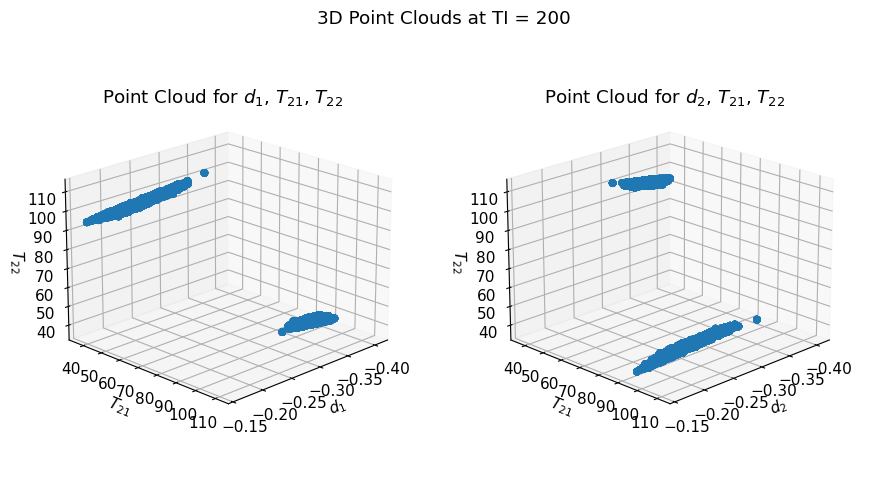

In [9]:
fig = plt.figure(figsize=(9,5), tight_layout=True)

iTI = 0
TI_oi = TI_DATA[iTI]

ax = fig.add_gridspec(1,2)

ax1 = fig.add_subplot(ax[0], projection = '3d')

ax1.scatter(param_estimates[iTI,:,0], param_estimates[iTI,:,2], param_estimates[iTI,:,3], alpha = 0.7, cmap = 'turbo')
ax1.set_xlabel(ParamTitle_4p[0])
ax1.set_ylabel(ParamTitle_4p[2])
ax1.set_zlabel(ParamTitle_4p[3])
ax1.set_title(f'Point Cloud for {ParamTitle_4p[0]}, {ParamTitle_4p[2]}, {ParamTitle_4p[3]}', y=1.0, pad=-10)
ax1.view_init(20,45)
ax1.dist = 12

ax1 = fig.add_subplot(ax[1], projection = '3d')

ax1.scatter(param_estimates[iTI,:,1], param_estimates[iTI,:,2], param_estimates[iTI,:,3], alpha = 0.7, cmap = 'turbo')
ax1.set_xlabel(ParamTitle_4p[1])
ax1.set_ylabel(ParamTitle_4p[2])
ax1.set_zlabel(ParamTitle_4p[3])
ax1.set_title(f'Point Cloud for {ParamTitle_4p[1]}, {ParamTitle_4p[2]}, {ParamTitle_4p[3]}', y=1.0, pad=-10)
ax1.view_init(20,45)
ax1.dist = 12

fig.suptitle(f"3D Point Clouds at TI = {TI_oi}")

plt.show()

/tmp/ipykernel_720165/4064408580.py:10: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax1.scatter(param_estimates[iTI,:,0], param_estimates[iTI,:,1], param_estimates[iTI,:,2], alpha = 0.7, cmap = 'turbo')
/tmp/ipykernel_720165/4064408580.py:16: MatplotlibDeprecationWarning: The dist attribute was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  ax1.dist = 12
/tmp/ipykernel_720165/4064408580.py:20: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax1.scatter(param_estimates[iTI,:,0], param_estimates[iTI,:,1], param_estimates[iTI,:,3], alpha = 0.7, cmap = 'turbo')
/tmp/ipykernel_720165/4064408580.py:26: MatplotlibDeprecationWarning: The dist attribute was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  ax1.dist = 12


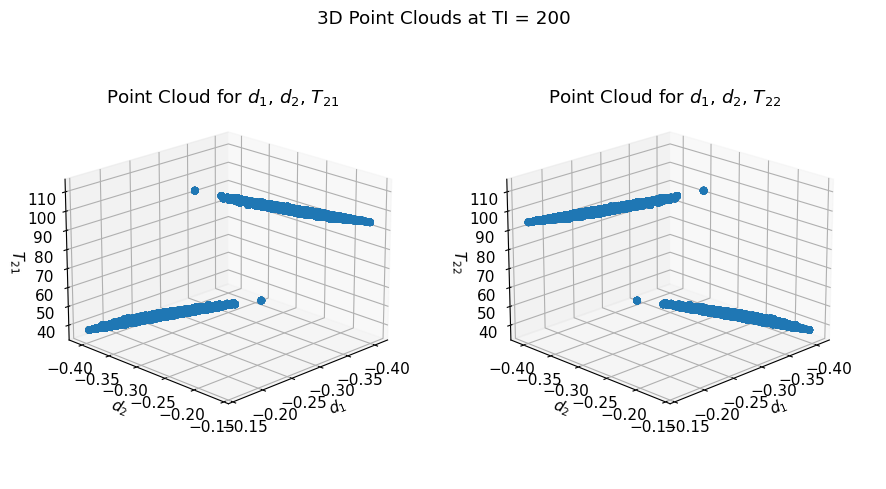

In [10]:
fig = plt.figure(figsize=(9,5), tight_layout=True)

iTI = 0
TI_oi = TI_DATA[iTI]

ax = fig.add_gridspec(1,2)

ax1 = fig.add_subplot(ax[0], projection = '3d')

ax1.scatter(param_estimates[iTI,:,0], param_estimates[iTI,:,1], param_estimates[iTI,:,2], alpha = 0.7, cmap = 'turbo')
ax1.set_xlabel(ParamTitle_4p[0])
ax1.set_ylabel(ParamTitle_4p[1])
ax1.set_zlabel(ParamTitle_4p[2])
ax1.set_title(f'Point Cloud for {ParamTitle_4p[0]}, {ParamTitle_4p[1]}, {ParamTitle_4p[2]}', y=1.0, pad=-10)
ax1.view_init(20,45)
ax1.dist = 12

ax1 = fig.add_subplot(ax[1], projection = '3d')

ax1.scatter(param_estimates[iTI,:,0], param_estimates[iTI,:,1], param_estimates[iTI,:,3], alpha = 0.7, cmap = 'turbo')
ax1.set_xlabel(ParamTitle_4p[0])
ax1.set_ylabel(ParamTitle_4p[1])
ax1.set_zlabel(ParamTitle_4p[3])
ax1.set_title(f'Point Cloud for {ParamTitle_4p[0]}, {ParamTitle_4p[1]}, {ParamTitle_4p[3]}', y=1.0, pad=-10)
ax1.view_init(20,45)
ax1.dist = 12

fig.suptitle(f"3D Point Clouds at TI = {TI_oi}")

plt.show()

In [11]:
m = 10000
n = 100
SNR = 1000
TIs = [200, 300, 400, 500, 600, 700, 800, 900]
N_PLOTS = 5
N_PARAMS = 4

In [12]:
datas = np.load("MH_DATA/datas_pc.npy")
combined_datas = np.load("MH_DATA/combined_datas_pc.npy")

In [13]:
def create_huge_figure(datas, param_estimates, fileName = None, dpi = 100, lower_bound = 0, upper_bound = 300, param_option = 1):
    # len(TIs) by N_PLOTS + 1 subplots
    fig, axs = plt.subplots(len(TIs), N_PLOTS + 2, figsize = (18, 20))
    fig.subplots_adjust(hspace = 0.6)
    fig.suptitle(f'{ParamTitle_4p[2*param_option]} and {ParamTitle_4p[2*param_option+1]} Point Clouds')
    for i in range(len(TIs)):
        # row title to the left, unrotated
        plt.text(-0.6, 0.5, f"TI = {TIs[i]}", fontsize = 15, rotation = 90, ha = 'center', va = 'center', transform = axs[i, 0].transAxes)

        TI_oi = TI_DATA[i]
        temp_true_params = [d_value(TI_oi, c1, T11), d_value(TI_oi, c2, T12), T21, T22]

        for j in range(N_PLOTS):
            data = datas[i, j]
            axs[i, j].scatter(data[:,2*param_option], data[:,2*param_option+1], s = 1, alpha = 0.1)
            axs[i, j].set_xlabel(ParamTitle_4p[2*param_option])
            axs[i, j].set_ylabel(ParamTitle_4p[2*param_option+1])
            axs[i, j].set_xlim(lower_bound, upper_bound)
            axs[i, j].set_ylim(lower_bound, upper_bound)
            axs[i, j].set_aspect('equal')
            axs[i, j].axvline(x = temp_true_params[2*param_option], linewidth=1, color='k', ls = '--')
            axs[i, j].axvline(x = temp_true_params[2*param_option+1], linewidth=1, color='k', ls = '--')
            axs[i, j].axhline(y = temp_true_params[2*param_option], linewidth=1, color='k', ls = '--')
            axs[i, j].axhline(y = temp_true_params[2*param_option+1], linewidth=1, color='k', ls = '--')


        # use combined data
        axs[i, N_PLOTS].scatter(combined_datas[i][:,2*param_option], combined_datas[i][:,2*param_option+1], s = 1, alpha = 0.005)
        axs[i, N_PLOTS].set_title(f"n = {n}", fontsize = 12)
        axs[i, N_PLOTS].set_xlabel(ParamTitle_4p[2*param_option])
        axs[i, N_PLOTS].set_ylabel(ParamTitle_4p[2*param_option+1])
        axs[i, N_PLOTS].set_xlim(lower_bound, upper_bound)
        axs[i, N_PLOTS].set_ylim(lower_bound, upper_bound)
        axs[i, N_PLOTS].set_aspect('equal')
        axs[i, N_PLOTS].axvline(x = temp_true_params[2*param_option], linewidth=1, color='k', ls = '--')
        axs[i, N_PLOTS].axvline(x = temp_true_params[2*param_option+1], linewidth=1, color='k', ls = '--')
        axs[i, N_PLOTS].axhline(y = temp_true_params[2*param_option], linewidth=1, color='k', ls = '--')
        axs[i, N_PLOTS].axhline(y = temp_true_params[2*param_option+1], linewidth=1, color='k', ls = '--')

        axs[i, N_PLOTS+1].scatter(param_estimates[i,:,2*param_option], param_estimates[i,:,2*param_option+1], s = 1, alpha = 0.005)
        axs[i, N_PLOTS+1].set_title(f"n = {var_reps}", fontsize = 12)
        axs[i, N_PLOTS+1].set_xlabel(ParamTitle_4p[2*param_option])
        axs[i, N_PLOTS+1].set_ylabel(ParamTitle_4p[2*param_option+1])
        axs[i, N_PLOTS+1].set_xlim(lower_bound, upper_bound)
        axs[i, N_PLOTS+1].set_ylim(lower_bound, upper_bound)
        axs[i, N_PLOTS+1].set_aspect('equal')
        axs[i, N_PLOTS+1].axvline(x = temp_true_params[2*param_option], linewidth=1, color='k', ls = '--')
        axs[i, N_PLOTS+1].axvline(x = temp_true_params[2*param_option+1], linewidth=1, color='k', ls = '--')
        axs[i, N_PLOTS+1].axhline(y = temp_true_params[2*param_option], linewidth=1, color='k', ls = '--')
        axs[i, N_PLOTS+1].axhline(y = temp_true_params[2*param_option+1], linewidth=1, color='k', ls = '--')

    if fileName:
        plt.savefig(fileName, dpi = dpi)


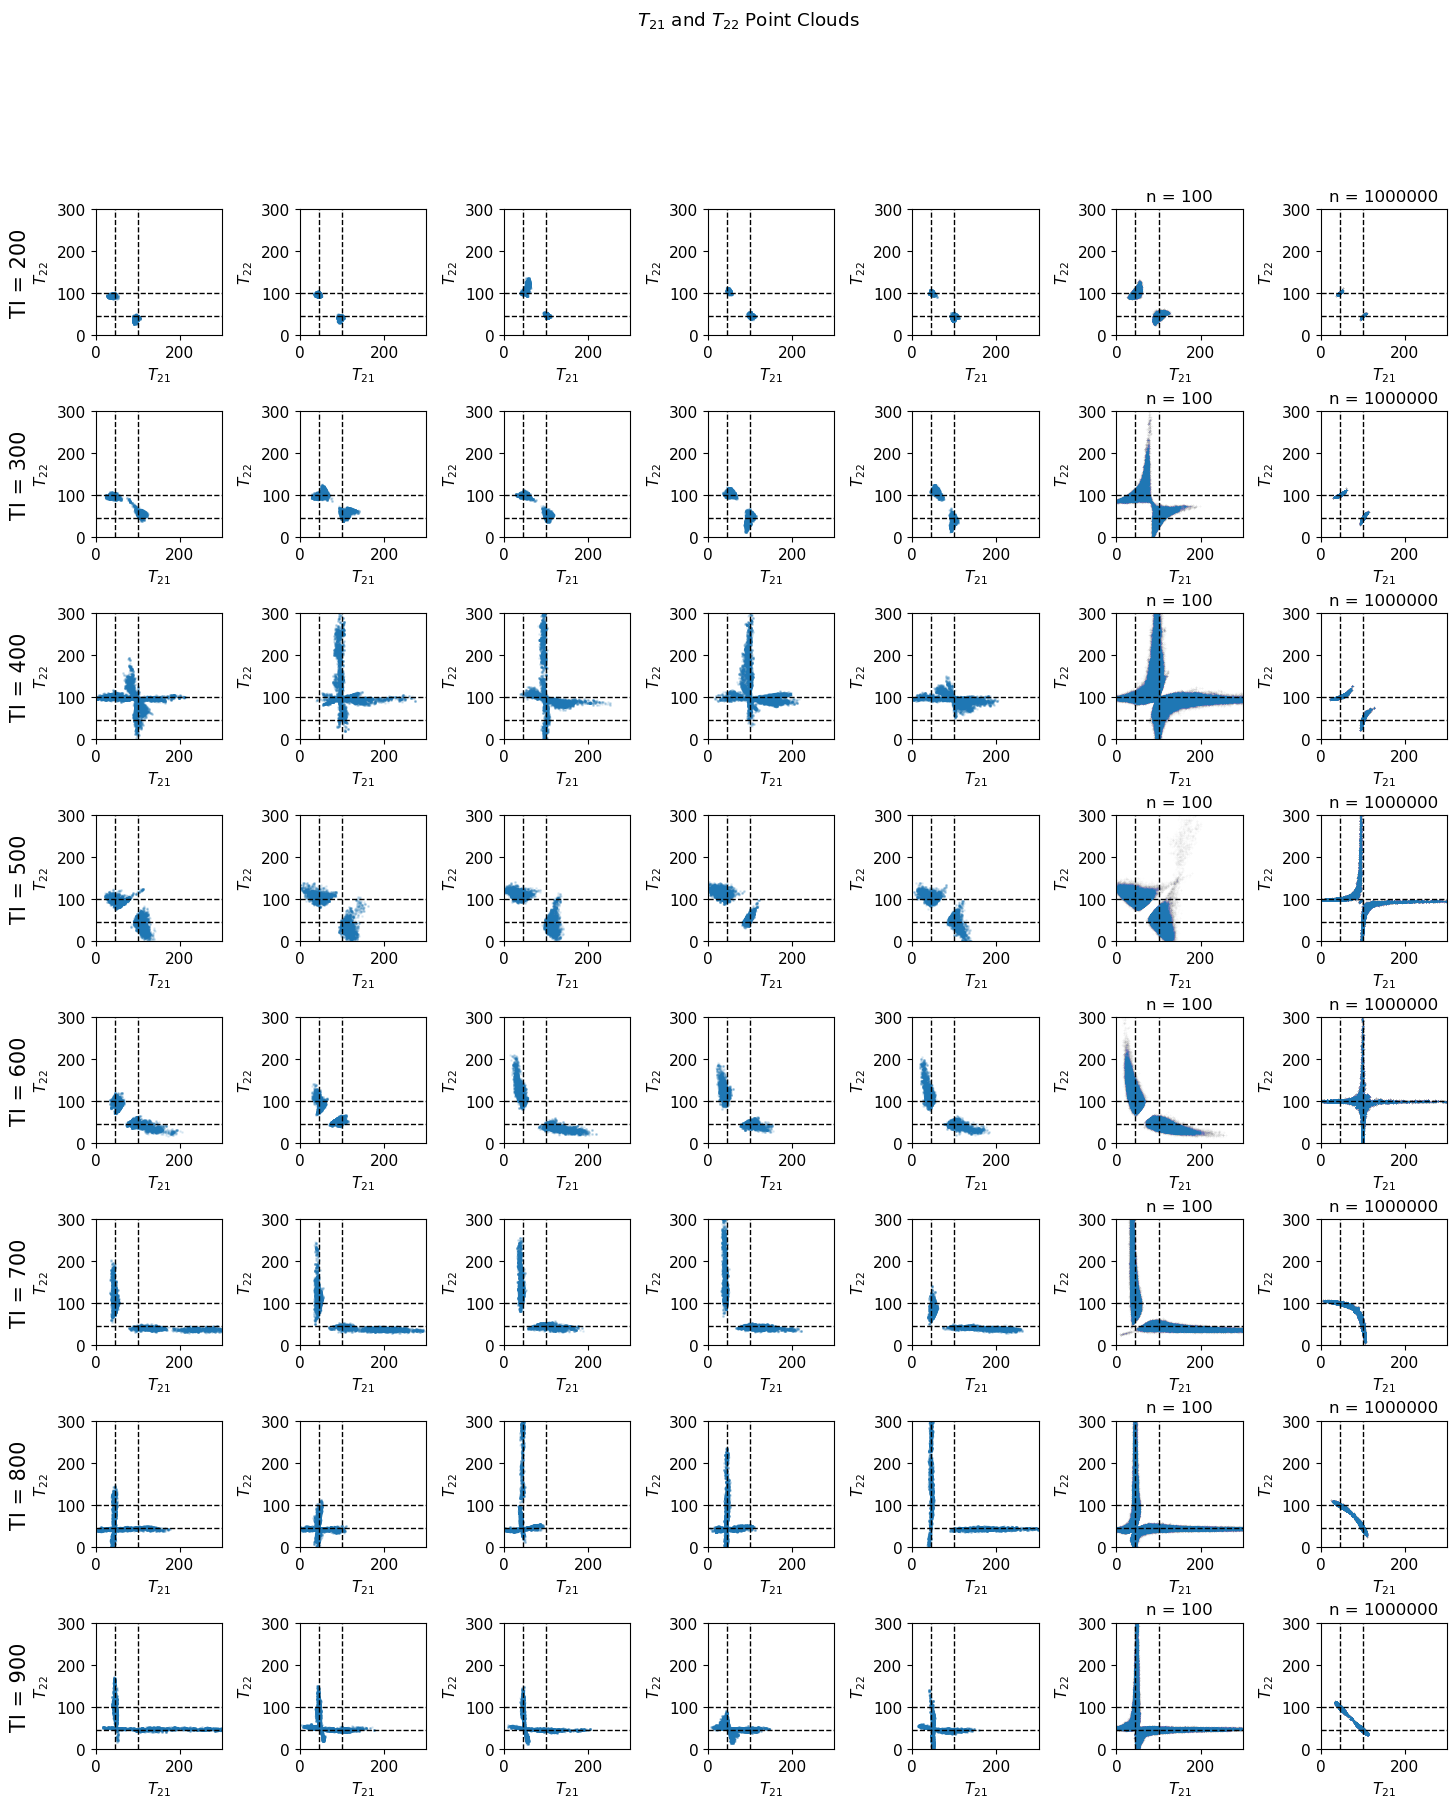

In [16]:
create_huge_figure(datas, param_estimates, lower_bound = 0, upper_bound = 300, param_option = 1)